In [6]:
# ========================
# 📦 Importar librerías
# ========================
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymysql
import geopandas as gpd
import pycountry
from dotenv import load_dotenv

# ========================
# 🔐 Cargar variables de entorno
# ========================
load_dotenv()
DB_HOST = os.getenv('DB_HOST')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_NAME = os.getenv('DB_NAME')

# ========================
# 🔌 Conexión a la base de datos
# ========================
conn = pymysql.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME
)



C:\Users\jcall\AppData\Local\Temp\ipykernel_6604\3383963174.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Último año con datos completos: 2019
Incluye Francia: False


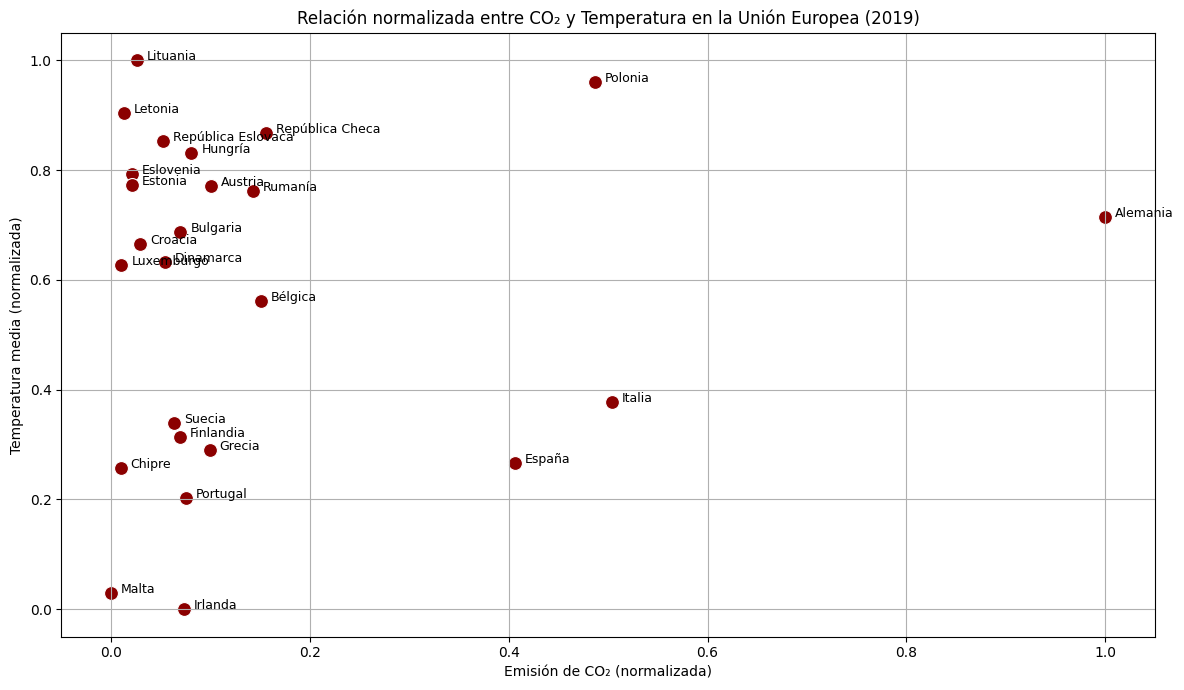

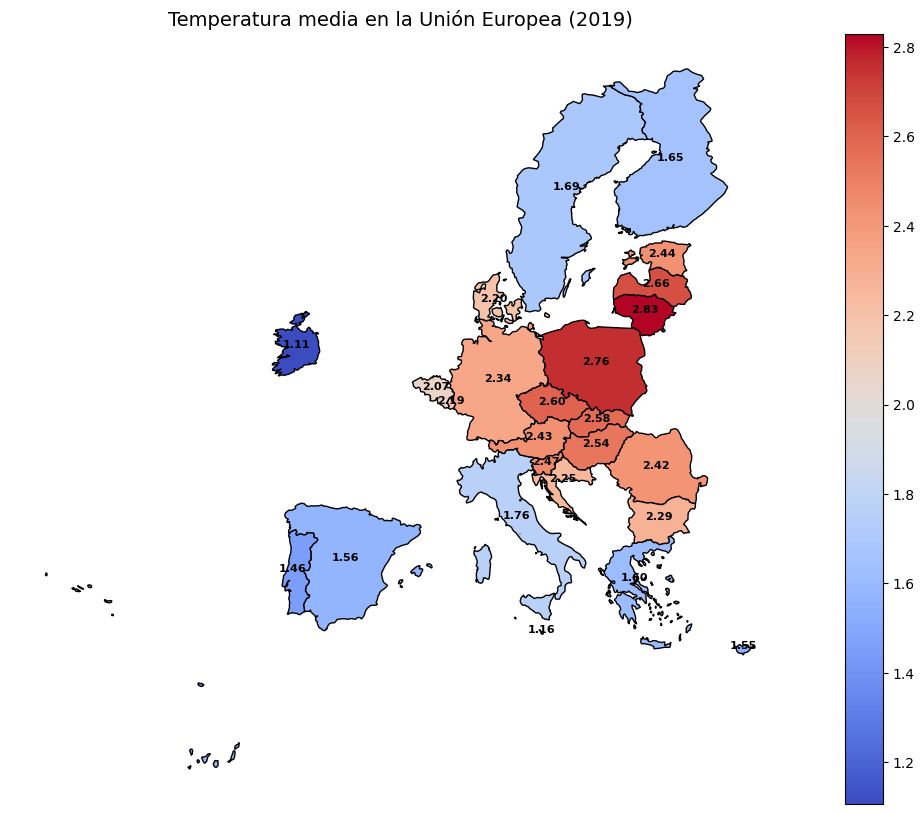

In [7]:
# ========================
# 📄 Consulta SQL (hasta 2019)
# ========================
query = """
SELECT 
    h.anio,
    p.codigo AS pais_codigo,
    p.nombre AS pais_nombre,
    i.descripcion AS indicador,
    h.valor
FROM hechos h
JOIN paises p ON h.pais_id = p.codigo
JOIN indicadores i ON h.indicador_id = i.id
JOIN subcontinentes s ON p.subcontinente_id = s.id
WHERE i.id IN (1, 2)
  AND s.id = 17
  AND h.anio BETWEEN 2000 AND 2021
ORDER BY pais_nombre, anio, indicador;
"""

# ========================
# 📥 Ejecutar consulta
# ========================
df = pd.read_sql(query, conn)
# conn.close()

# ========================
# 🔁 Reorganizar: pivot table
# ========================
df_pivot = df.pivot_table(
    index=["anio", "pais_nombre", "pais_codigo"], 
    columns="indicador", 
    values="valor"
).reset_index()

# ========================
# ❗ Filtrar filas completas
# ========================
df_pivot = df_pivot.dropna(subset=["Temperatura media", "Emisión de CO₂"])

# ========================
# 📅 Obtener último año con datos válidos
# ========================
latest_year = df_pivot["anio"].max()
df_year = df_pivot[df_pivot["anio"] == latest_year].copy()
print(f"Último año con datos completos: {latest_year}")

# ========================
# 🌍 Convertir ISO2 → ISO3
# ========================
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df_year["pais_codigo"] = df_year["pais_codigo"].apply(iso2_to_iso3)
df_year = df_year[df_year["pais_codigo"].notna()]

# ========================
# 🌍 Cargar shapefile
# ========================
shapefile_path = "./../../data/visualizacion/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
print("Incluye Francia:", "FRA" in world["ISO_A3"].unique())
# ========================
# 🔗 Filtrar países válidos y merge
# ========================
valid_iso3 = set(world["ISO_A3"])
df_year = df_year[df_year["pais_codigo"].isin(valid_iso3)]

map_data = world.merge(df_year, how='inner', left_on='ISO_A3', right_on='pais_codigo')
map_data = map_data[map_data["geometry"].notna()]

# ========================
# 📊 SCATTERPLOT NORMALIZADO CON ETIQUETAS
# ========================
df_norm = df_year.copy()
df_norm["CO2_norm"] = (df_norm["Emisión de CO₂"] - df_norm["Emisión de CO₂"].min()) / (df_norm["Emisión de CO₂"].max() - df_norm["Emisión de CO₂"].min())
df_norm["Temp_norm"] = (df_norm["Temperatura media"] - df_norm["Temperatura media"].min()) / (df_norm["Temperatura media"].max() - df_norm["Temperatura media"].min())

plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_norm,
    x="CO2_norm", 
    y="Temp_norm",
    s=100,  # tamaño del punto
    color='darkred'
)
# Etiquetas con nombres de país
for i, row in df_norm.iterrows():
    plt.text(
        row["CO2_norm"] + 0.01,
        row["Temp_norm"],
        row["pais_nombre"],
        fontsize=9
    )

plt.title(f"Relación normalizada entre CO₂ y Temperatura en la Unión Europea ({latest_year})")
plt.xlabel("Emisión de CO₂ (normalizada)")
plt.ylabel("Temperatura media (normalizada)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================
# 🗺️ MAPA DE TEMPERATURA CON ETIQUETAS
# ========================
if map_data.empty:
    print("❗ No hay datos válidos para graficar el mapa.")
else:
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))

    map_data.plot(
        column="Temperatura media", 
        cmap="coolwarm", 
        legend=True, 
        ax=ax,
        edgecolor='black'
    )

    # Agregar texto sobre cada país
    for idx, row in map_data.iterrows():
        if row["geometry"].geom_type in ["Polygon", "MultiPolygon"]:
            try:
                centroid = row["geometry"].centroid
                ax.text(
                    centroid.x,
                    centroid.y,
                    f'{row["Temperatura media"]:.2f}',
                    ha='center',
                    fontsize=8,
                    color='black',
                    weight='bold'
                )
            except:
                pass

    ax.set_title(f"Temperatura media en la Unión Europea ({latest_year})", fontsize=14)
    ax.axis('off')
    plt.show()




C:\Users\jcall\AppData\Local\Temp\ipykernel_6604\4068928625.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_temp = pd.read_sql(query_temp, conn)


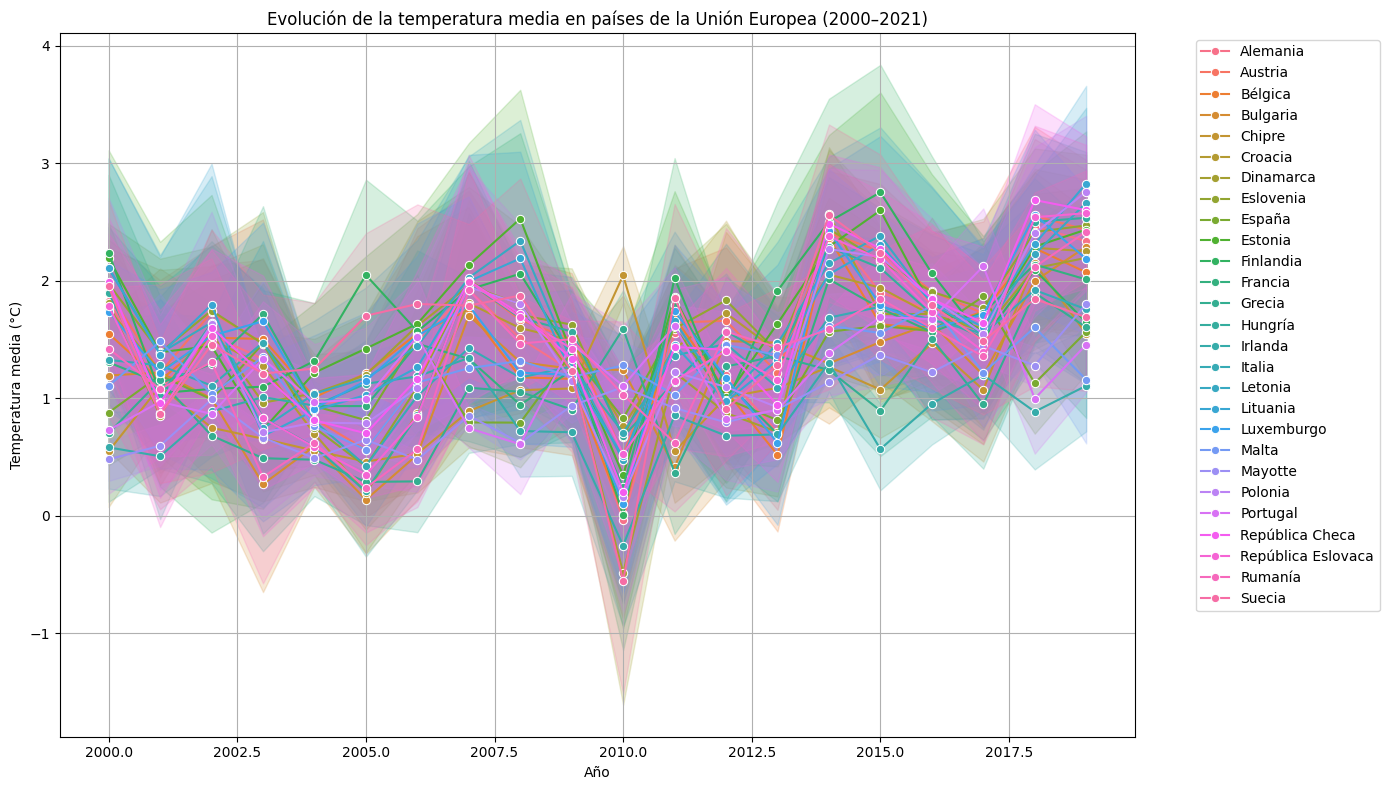

In [8]:
# ========================
# 📄 Consulta: solo temperatura
# ========================
query_temp = """
SELECT 
    h.anio,
    p.nombre AS pais_nombre,
    h.valor AS temperatura
FROM hechos h
JOIN paises p ON h.pais_id = p.codigo
JOIN indicadores i ON h.indicador_id = i.id
JOIN subcontinentes s ON p.subcontinente_id = s.id
WHERE i.id = 1         -- Temperatura media
  AND s.id = 17        -- Unión Europea
  AND h.anio BETWEEN 2000 AND 2021
ORDER BY h.anio, p.nombre;
"""

# ========================
# 📥 Ejecutar y preparar datos
# ========================
df_temp = pd.read_sql(query_temp, conn)

# ========================
# 📊 Línea de temperatura por país
# ========================
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=df_temp,
    x="anio", 
    y="temperatura", 
    hue="pais_nombre",
    marker="o"
)

plt.title("Evolución de la temperatura media en países de la Unión Europea (2000–2021)")
plt.xlabel("Año")
plt.ylabel("Temperatura media (°C)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\jcall\AppData\Local\Temp\ipykernel_6604\2852137254.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_co2 = pd.read_sql(query_co2, conn)


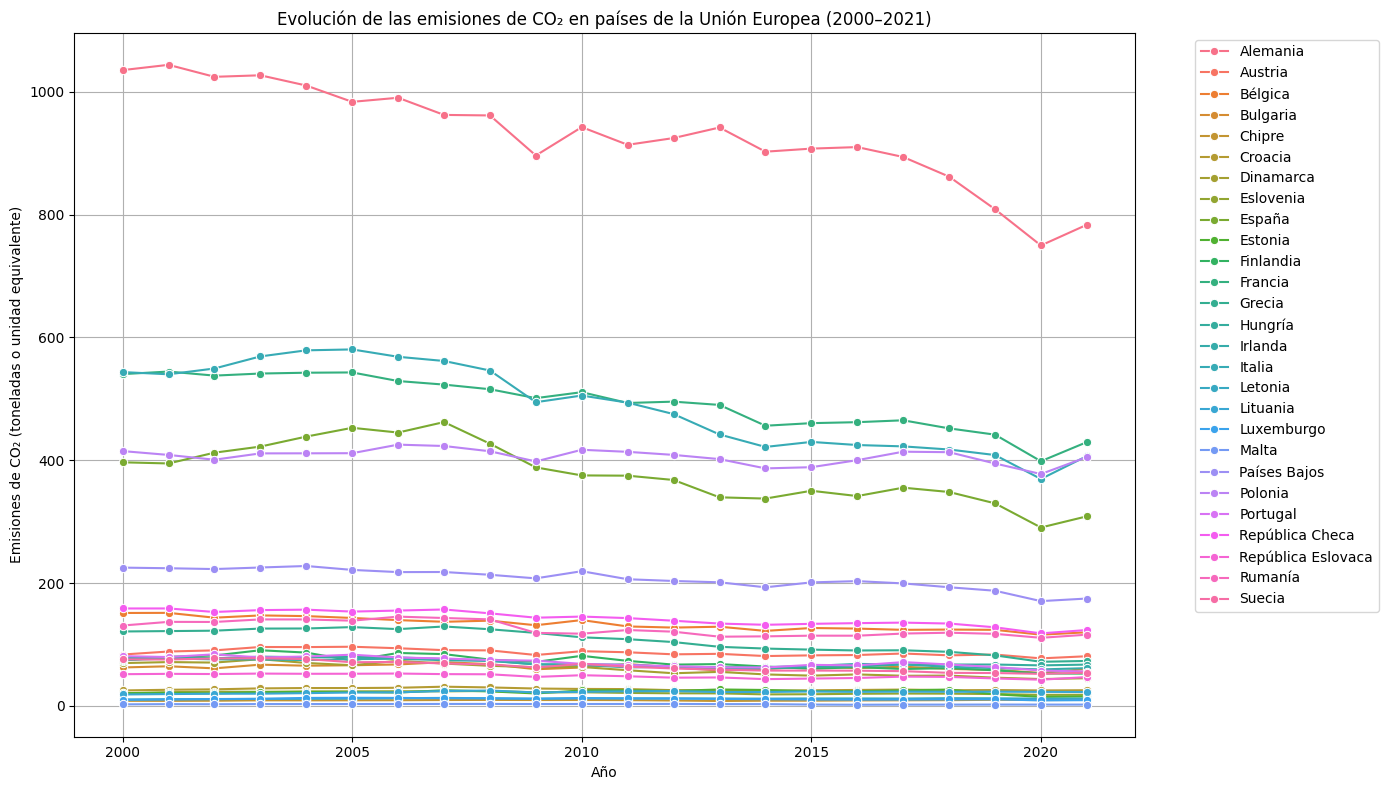

In [9]:
# ========================
# 📄 Consulta: solo emisiones de CO₂
# ========================
query_co2 = """
SELECT 
    h.anio,
    p.nombre AS pais_nombre,
    h.valor AS emisiones
FROM hechos h
JOIN paises p ON h.pais_id = p.codigo
JOIN indicadores i ON h.indicador_id = i.id
JOIN subcontinentes s ON p.subcontinente_id = s.id
WHERE i.id = 2         -- Emisiones de CO₂
  AND s.id = 17        -- Unión Europea
  AND h.anio BETWEEN 2000 AND 2021
ORDER BY h.anio, p.nombre;
"""

# ========================
# 📥 Ejecutar y preparar datos
# ========================
conn = pymysql.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME
)

df_co2 = pd.read_sql(query_co2, conn)
conn.close()

df_co2 = df_co2.dropna(subset=["emisiones"])

# ========================
# 📊 Línea de emisiones por país
# ========================
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=df_co2,
    x="anio", 
    y="emisiones", 
    hue="pais_nombre",
    marker="o"
)

plt.title("Evolución de las emisiones de CO₂ en países de la Unión Europea (2000–2021)")
plt.xlabel("Año")
plt.ylabel("Emisiones de CO₂ (toneladas o unidad equivalente)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\jcall\AppData\Local\Temp\ipykernel_6604\3732160621.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_evo = pd.read_sql(query_evo, conn)
C:\Users\jcall\AppData\Local\Temp\ipykernel_6604\3732160621.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


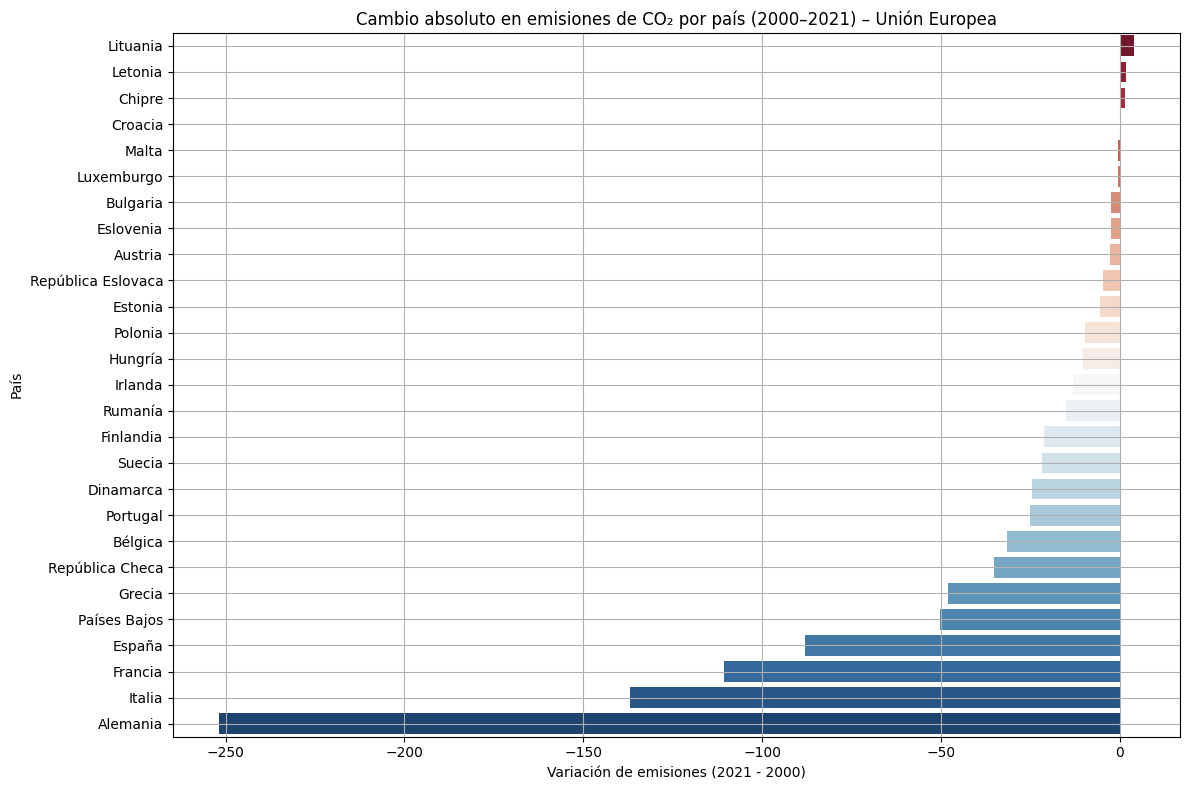

In [10]:
# Ejecutar consulta
query_evo = """
SELECT 
    h.anio,
    p.nombre AS pais_nombre,
    h.valor AS emisiones
FROM hechos h
JOIN paises p ON h.pais_id = p.codigo
WHERE h.indicador_id = 2
  AND h.anio IN (2000, 2021)
  AND p.subcontinente_id = 17
ORDER BY p.nombre, h.anio;
"""

conn = pymysql.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME
)

df_evo = pd.read_sql(query_evo, conn)
conn.close()

# Pivot para tener columnas por año
df_wide = df_evo.pivot(index="pais_nombre", columns="anio", values="emisiones").reset_index()
df_wide.columns.name = None  # quitar nombre del índice de columnas

# Calcular diferencia absoluta y porcentual
df_wide["variacion_abs"] = df_wide[2021] - df_wide[2000]
df_wide["variacion_pct"] = ((df_wide[2021] - df_wide[2000]) / df_wide[2000]) * 100

# Ordenar por variación
df_sorted = df_wide.sort_values(by="variacion_abs", ascending=False)

# Gráfico
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_sorted,
    x="variacion_abs",
    y="pais_nombre",
    palette="RdBu"
)
plt.title("Cambio absoluto en emisiones de CO₂ por país (2000–2021) – Unión Europea")
plt.xlabel("Variación de emisiones (2021 - 2000)")
plt.ylabel("País")
plt.grid(True)
plt.tight_layout()
plt.show()
